In [3]:
import pandas as pd 
import numpy as np
import pickle
import json
import requests
import os 
from os import makedirs
from os.path import join, exists
from datetime import date, timedelta
from urllib.request import urlretrieve

from collections import Counter
import re
import image_scraper
import six


font_path = '/System/Library/Fonts/Hiragino Sans GB.ttc'
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = "Hiragino Sans GB"
from wordcloud import WordCloud


from matplotlib.pyplot import imshow
from PIL import Image
%matplotlib inline
import colorgram
import calmap

from bokeh.io import output_file, show, output_notebook
from bokeh.models import ColumnDataSource, RangeTool
from bokeh.palettes import Category20b, cividis, inferno
from bokeh.plotting import figure
from bokeh.transform import factor_cmap, cumsum
from bokeh.layouts import column
from math import pi

from sklearn.decomposition import LatentDirichletAllocation as LDA
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
from sklearn.feature_extraction.text import CountVectorizer


import spacy
nlp_ja = spacy.load("ja_core_news_lg")
nlp_en = spacy.load("en_core_web_lg")
import nagisa

# Helper Functions

## Graphs

### Bar Chart generic

In [4]:
def barchart(counted_data, counts, output_here=True, 
             save_filename="plot", plot_height=350, plot_width=800, title="Title", bgcolor = "#2b2b2b"):
    # either display in the notebook or save file 
    if output_here:
        output_notebook()
    else:
        output_file(save_filename+".html")
            
    source = ColumnDataSource(data=dict(counted_data=counted_data, counts=counts))
    p = figure(x_range=counted_data, plot_height=plot_height, plot_width=plot_width, toolbar_location=None, title=title)
    
    p.vbar(x='counted_data',
           top='counts', 
           width=0.8, 
           source=source, 
           line_color='white', 
           fill_color=factor_cmap('counted_data', palette=cividis(len(counted_data)), factors=counted_data))
    
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.y_range.start = 0
    p.xaxis.major_label_orientation = 1.2
    p.background_fill_color = bgcolor
    
    show(p)

In [5]:
barchart(['word1', 'word2', 'word3'], [10, 50, 100])

Loading BokehJS ...

### Pie Chart generic

In [6]:
def piechart(df, df_items_col, df_values_col, title="Title"):
    # create columns for the angle for each slice and its colour
    df['angle'] = df[df_values_col] / df[df_values_col].sum() * 2*pi
    df['color'] = cividis(len(df))
    
    p = figure(plot_height=350, title=title, toolbar_location=None,
           tools="hover", tooltips="@{}: @{}".format(df_items_col, df_values_col), x_range=(-0.5, 1.0))
    p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend_field=df_items_col, source=df)

    p.axis.axis_label=None
    p.axis.visible=False
    p.grid.grid_line_color = None

    show(p)
    

In [7]:
porg = pd.DataFrame.from_dict({"item1": 10, "item2": 30, "item3": 50}, orient='index')
porg = porg.reset_index()
porg.columns = ['items_col', 'values_col']

piechart(porg, "items_col", "values_col")

NumExpr defaulting to 8 threads.


### Line graph with range 

In [8]:
def line_range(dates, data, start_date_number=0, end_date_number=30, label="Label", line_colour="maroon"):
    source = ColumnDataSource(data=dict(date=dates, data=data))
    
    p = figure(plot_height=300, plot_width=1000, tools="xpan", toolbar_location=None,
           x_axis_type="datetime", x_axis_location="above",
           background_fill_color="#efefef", x_range=(dates[start_date_number], dates[end_date_number]))
    
    p.line('date', 'data', source=source, color=line_colour, line_width=2)
    p.yaxis.axis_label = label
    
    select = figure(title="Drag slider",
                plot_height=130, plot_width=1000, y_range=p.y_range,
                x_axis_type="datetime", y_axis_type=None,
                tools="", toolbar_location=None, 
                background_fill_color= "#2b2b2b")
                #background_fill_color="#efefef")
    
    range_tool = RangeTool(x_range=p.x_range)
    range_tool.overlay.fill_color = "white"
    range_tool.overlay.fill_alpha = 0.2
    
    select.line('date', 'data', source=source)
    select.ygrid.grid_line_color = None
    select.add_tools(range_tool)
    select.toolbar.active_multi = range_tool
    
    show(column(p, select))

In [9]:
dates = np.array(['2000-03-01', '2000-03-02', '2000-03-03',
                 '2000-03-04', '2000-03-05', '2000-03-06',
                 '2000-03-07', '2000-03-08', '2000-03-09'], dtype=np.datetime64)
data = np.array([100, 300, 100, 100, 300, 100, 100, 300, 20])
line_range(dates, data, 0, 3, label="My Label", line_colour="deepskyblue")

/Users/dea/opt/anaconda3/lib/python3.7/site-packages/bokeh/core/property/bases.py:237: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return new == old
/Users/dea/opt/anaconda3/lib/python3.7/site-packages/bokeh/core/property/bases.py:237: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return new == old


# Data Processing and Cleaning 

### Basic filter out data you need from the tweet downloads

In [10]:
# data to keep 
data_to_keep = [
    'created_at',
    'id',
    'full_text',
    'entities',
    'media',
    'in_reply_to_status_id',
    'in_reply_to_user_id',
    'is_quote_status',
    'retweet_count',
    'favorite_count'
]


def extract_useful_info(tweets, handle):
    clean_tweets = []
    for i in range(len(tweets)):
        tweet = tweets[i]._json
        clean_tweet = {
            'created_at': tweet['created_at'],
            'id': tweet['id'],
            'full_text': tweet['full_text'],
            'url': "https://twitter.com/"+ handle +"/status/" + str(tweet['id']),
            'entities': tweet['entities'],
            'in_reply_to_status_id': tweet['in_reply_to_status_id'],
            'in_reply_to_user_id': tweet['in_reply_to_user_id'],
            'is_quote_status': tweet['is_quote_status'],
            'retweet_count': tweet['retweet_count'],
            'favorite_count': tweet['favorite_count']     
        }
        clean_tweets.append(clean_tweet)
    return clean_tweets

### Feature extraction 
once the data is in a dataframe format 

In [11]:
def get_time_features(df):
    df['date'] = pd.to_datetime(df['created_at'])
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year 
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['hour'] = df['date'].dt.hour
    df['weekday'] = df['date'].dt.weekday
    df['date'] = pd.to_datetime(df['date'].apply(lambda x : str(x).split(" ")[0]))
    return df

In [12]:
def get_hashtags(df):
    df['hashtags'] = df['entities'].apply(lambda x : ";".join(hashtag['text'] for hashtag in x['hashtags']))
    df['number_hashtags_used'] = df['entities'].apply(lambda x : len(x['hashtags']))
    return df

In [13]:
# get both the screen name (handle) and name for each user mentioned in a given tweet. separated by ;
def get_user_metnions(df):
    df['user_mentions_handle'] = df['entities'].apply(lambda x : ";".join([user['screen_name'] for user in x['user_mentions']]))
    df['user_mentions_name'] = df['entities'].apply(lambda x : ";".join([user['name'] for user in x['user_mentions']]))
    return df

In [14]:
# get any urls mentioned in the tweet. separated by ;
def get_mentioned_urls(df):
    df['mentioned_urls'] = df['entities'].apply(lambda x : ";".join([url['expanded_url'] for url in x['urls']]))
    return df

In [15]:
# get a column for True or False for has any media (images or video) or not 
# derive column with all the media link separated by ;
# deravie a column with all the media types separated by ; in the same order as the links
def get_contains_media(df):
    df['has_media'] = df['entities'].apply(lambda x : "media_url" in str(x))
    df['media_urls'] = ""
    df.loc[df['has_media'] == True, 'media_urls'] = df[df['has_media'] == True]['entities'].apply(
        lambda x : ";".join([media_url['media_url_https'] for media_url in x['media']]) )
    df['media_types'] = ""
    df.loc[df['has_media'] == True, 'media_types'] = df[df['has_media'] == True]['entities'].apply(
        lambda x : ";".join([media_type['type'] for media_type in x['media']]) )
    
    return df

In [16]:
# check if the tweet is a retweet or not
def get_is_retweet(df):   
    df["is_retweet"] = df['full_text'].apply(lambda x : "RT" in x)
    return df 

In [17]:
# filter data based on time 
def filter_by_date(df):
    df = df[df['year'] == 2020] 
    return df

In [18]:
def prep_data(df):
    df = get_time_features(df)
    df = get_hashtags(df)
    df = get_user_metnions(df)
    df = get_mentioned_urls(df)
    df = get_contains_media(df)
    df = filter_by_date(df)
    df = get_is_retweet(df)
    return df

## Load and transform data

In [19]:
tweets_path = "../Data/tweets/"

In [20]:
# get useful json type data from the api 
# GOVERNMENT ACCOUNTS #
tweets_ja_pm_all = pickle.load( open( tweets_path + "tweets_kantei_nov14.p", "rb" ) )
tweets_ja_pm_all = extract_useful_info(tweets_ja_pm_all, 'kantei')

tweets_uk_pm_all = pickle.load( open( tweets_path + "tweets_10downingstreet_nov14.p", "rb" ) )
tweets_uk_pm_all = extract_useful_info(tweets_uk_pm_all, "10DowningStreet")

In [21]:
# GOVERNMENT ACCOUNTS #
# put the data into a df for each and add column for the handle so that you can merge the dfs 
tweets_ja_pm_df = pd.DataFrame(tweets_ja_pm_all).set_index("id")
tweets_ja_pm_df['account'] = 'kantei'
tweets_ja_pm_df['account_encode'] = 'JPPM'

tweets_uk_pm_df = pd.DataFrame(tweets_uk_pm_all).set_index("id")
tweets_uk_pm_df['account'] = '10DowningStreet'
tweets_uk_pm_df['account_encode'] = 'UKPM'

# merge the dfs 
tweets_df_gov = tweets_ja_pm_df.append(tweets_uk_pm_df)

# added features 
df = prep_data(tweets_df_gov)

/Users/dea/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
len(df)

3296

### Add translation for Japanese tweets

In [23]:
def batch_translate(texts_list, target_language="en"):
    results = []
    for text in texts_list:
        if isinstance(text, six.binary_type):
            text = text.decode("utf-8")
        try:
            result = translate_client.translate(text, target_language="en")["translatedText"]
            # just replace the quotes and apostophies for readability; any other cleaning should happen later if necessary
            result = result.replace("&quot;", "'")
            result = result.replace("&#39;", "'")
        except: 
            result = ""
        results.append(result)  
    return results

In [24]:
df = pd.read_csv(os.path.join(tweets_path, "df_tweets_nov14.csv"), index_col=0)

In [25]:
df.head()

,created_at,full_text,url,entities,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,retweet_count,favorite_count,account,...,hashtags,number_hashtags_used,user_mentions_handle,user_mentions_name,mentioned_urls,has_media,media_urls,media_types,is_retweet,translation
id,,,,,,,,,,,,,,,,,,,,,
1327175518978904064,Fri Nov 13 09:04:36 +0000 2020,【加藤官房長官・記者会見】本日（11月13日）午後の動画を掲載しました。https://t....,https://twitter.com/kantei/status/132717551897...,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,NaN,False,40,296,kantei,...,NaN,0,NaN,NaN,https://www.kantei.go.jp/jp/tyoukanpress/20201...,False,NaN,NaN,False,[Chief Cabinet Secretary Kato / Press Conferen...
1327171179556212736,Fri Nov 13 08:47:21 +0000 2020,《総理の動き》本日（11月13日）菅総理は官邸でオンラインで開催された日メコン首脳会議に出席...,https://twitter.com/kantei/status/132717117955...,"{'hashtags': [], 'symbols': [], 'user_mentions...",1.327146e+18,412940784.0,False,48,384,kantei,...,NaN,0,NaN,NaN,https://www.kantei.go.jp/jp/99_suga/actions/20...,True,https://pbs.twimg.com/media/EmsPI7UVEAAIoq7.jpg,photo,False,&lt;&lt; Movement of the Prime Minister &gt;&g...
1327146176064450560,Fri Nov 13 07:08:00 +0000 2020,#日メコン首脳会談\n@sugawitter,https://twitter.com/kantei/status/132714617606...,"{'hashtags': [{'text': '日メコン首脳会談', 'indices': ...",1.327146e+18,412940784.0,False,37,394,kantei,...,日メコン首脳会談,1,sugawitter,菅 義偉,NaN,False,NaN,NaN,False,#Mekong Summit Meeting @sugawitter
1327146172218298368,Fri Nov 13 07:07:59 +0000 2020,インド太平洋の中核であるメコン諸国🇻🇳🇰🇭🇱🇦🇲🇲🇹🇭と首脳会談を行いました。法の支配、海洋...,https://twitter.com/kantei/status/132714617221...,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,NaN,False,354,2273,kantei,...,NaN,0,NaN,NaN,NaN,True,https://pbs.twimg.com/media/Emr4TUOWEAEqjP_.jpg,photo,False,We had a summit meeting with the Mekong countr...
1327134798654173185,Fri Nov 13 06:22:47 +0000 2020,RT @Kantei_Saigai: https://t.co/RdelY42YII\n\n...,https://twitter.com/kantei/status/132713479865...,"{'hashtags': [{'text': '新型コロナウイルス', 'indices':...",NaN,NaN,False,170,0,kantei,...,新型コロナウイルス;5つの場面,2,Kantei_Saigai;sugawitter,首相官邸(災害・危機管理情報);菅 義偉,https://corona.go.jp/proposal/,False,NaN,NaN,True,RT @Kantei_Saigai: https://t.co/RdelY42YII #Ne...


# Basic Data Exploration 
- Hashtag counts and frequencies 
- Other user mentions and frequencies 
- Links: how much they were used and where did they point to 
- Media: how much was used and what type 
- Heatmap of the tweets over time 
- Most popular and retweeted tweets 
- Least popular and retweeted tweets 

## Hashtags

### compare hastag usage between accounts

In [26]:
total_number_hashtags_used = df.groupby('account')['number_hashtags_used'].sum() 
print("Total number of hashtags used: {}".format(total_number_hashtags_used))

Total number of hashtags used: account
10DowningStreet    1330
kantei              227
Name: number_hashtags_used, dtype: int64


### explore all hashtags per account

In [27]:
def get_hashtags_df(account):
    hashtags = df[df['account'] == account]['hashtags'].replace("", np.nan).dropna().tolist()
    hashtags_list = []
    for hashtag in hashtags:
        hashtags_list.extend(hashtag.split(";"))
    hashtags_df = pd.DataFrame.from_dict(dict(Counter(hashtags_list)), orient="index", columns=['count'])
    return hashtags_df

In [28]:
uk_hastags_df = get_hashtags_df('10DowningStreet')
jp_hastags_df = get_hashtags_df('kantei')

boris_hastags_df = get_hashtags_df('BorisJohnson')
abe_hastags_df = get_hashtags_df('AbeShinzo')

In [29]:
#uk_hastags_df.sort_values(by='count', ascending=False).head(10)

In [30]:
barchart(uk_hastags_df.nlargest(10, 'count').index.tolist(), uk_hastags_df.nlargest(10, 'count')['count'])

Loading BokehJS ...

In [31]:
#barchart(boris_hastags_df.nlargest(10, 'count').index.tolist(), boris_hastags_df.nlargest(10, 'count')['count'])

In [32]:
#jp_hastags_df.sort_values(by='count', ascending=False).head(10)

In [33]:
barchart(jp_hastags_df.nlargest(10, 'count').index.tolist(), jp_hastags_df.nlargest(10, 'count')['count'])

Loading BokehJS ...

In [34]:
#barchart(abe_hastags_df.nlargest(10, 'count').index.tolist(), abe_hastags_df.nlargest(10, 'count')['count'])

### hashtags trending over time - TODO 

## User Mentions

In [35]:
def get_usermentions_df(account):
    mentions = df[df['account'] == account]['user_mentions_name'].replace("", np.nan).dropna().tolist()
    mentions_list = []
    for mention in mentions:
        mentions_list.extend(mention.split(";"))
    mentions_df = pd.DataFrame.from_dict(dict(Counter(mentions_list)), orient="index", columns=['count'])
    return mentions_df

In [36]:
uk_usermentions_df = get_usermentions_df("10DowningStreet")
jp_usermentions_df = get_usermentions_df("kantei")

In [37]:
uk_usermentions_df.nlargest(10, 'count')

,count
Boris Johnson,388
Department of Health and Social Care,50
Matt Hancock,40
Professor Chris Whitty,39
HM Treasury,38
Sir Patrick Vallance,30
NHS England and NHS Improvement,28
Rishi Sunak,22
Dominic Raab,21
Department for Education,16


In [38]:
barchart(uk_usermentions_df.nlargest(10, 'count').index.tolist(), uk_usermentions_df.nlargest(10, 'count')['count'])

Loading BokehJS ...

In [39]:
jp_usermentions_df.nlargest(10, "count")

,count
首相官邸(災害・危機管理情報),205
菅 義偉,33
首相官邸,3
Joe Biden,2
Kamala Harris,2
caféふぅ,2
新型コロナウイルス感染症対策推進室（内閣官房）,2
総務省,1
Joko Widodo,1
World Economic Forum,1


In [40]:
barchart(jp_usermentions_df.nlargest(3, 'count').index.tolist(), jp_usermentions_df.nlargest(3, 'count')['count'])

Loading BokehJS ...

## Links in posts

In [41]:
def get_mentioned_urls(account):
    mentioned_fullurls = df[df['account']==account]['mentioned_urls'].replace("", np.nan).dropna().tolist()
    mentioned_urls = []
    for url in mentioned_fullurls:
        if url.startswith("https://"):
            try:
                mentioned_urls.append(re.search(r'https://(.*?)/', url).group(1))
            except:
                mentioned_urls.append(re.search(r'https://(.*?)', url).group(1))

        elif url.startswith("http://"):
            try:
                mentioned_urls.append(re.search(r'http://(.*?)/', url).group(1))
            except:
                mentioned_urls.append(re.search(r'http://(.*?)', url).group(1))

        elif url.startswith("www."):
            try:
                mentioned_urls.append(re.search(r'www.(.*?)/', url).group(1))
            except:
                mentioned_urls.append(re.search(r'www.(.*?)', url).group(1))

        else:
            mentioned_urls.append(url)
            
            
    mentioned_urls_df = pd.DataFrame.from_dict(dict(Counter(mentioned_urls)), orient="index", columns=['count'])
    return mentioned_urls_df
            

In [42]:
uk_mentioned_urls_df = get_mentioned_urls("10DowningStreet")

In [43]:
uk_mentioned_urls_df.nlargest(10, 'count')

,count
www.gov.uk,510
twitter.com,126
www.nhs.uk,48
nhs.uk,43
gov.uk,38
www.pscp.tv,7
,6
NHS.uk,5
coronavirus.data.gov.uk,3
www.facebook.com,3


In [44]:
ja_mentioned_urls_df = get_mentioned_urls("kantei")

In [45]:
ja_mentioned_urls_df.nlargest(10, 'count')

,count
www.kantei.go.jp,692
www.facebook.com,43
twitter.com,20
www.anzen.mofa.go.jp,19
instagram.com,14
facebook.com,13
www.pscp.tv,6
www.instagram.com,4
www.mhlw.go.jp,3
corona.go.jp,1


## Media usage

### compare media usage across accounts

In [46]:
number_posts_with_media = df.groupby('account')['has_media'].sum()
prop_posts_with_media = df.groupby('account')['has_media'].sum() / df.groupby('account')['has_media'].count()
print("Number of posts with media in them: {}".format(number_posts_with_media))
print("\n")
print("Proportion of posts with media in them: {}".format(prop_posts_with_media))

Number of posts with media in them: account
10DowningStreet    1612.0
kantei              417.0
Name: has_media, dtype: float64


Proportion of posts with media in them: account
10DowningStreet    0.720608
kantei             0.393768
Name: has_media, dtype: float64


#### Media usage in UK posts vs JP posts

In [47]:
uk_media = pd.DataFrame(df[df['account']=='10DowningStreet']['has_media'].value_counts()).reset_index()
piechart(uk_media, "index", "has_media", "Does the post have an image or video in it -- UK")

In [48]:
#boris_media = pd.DataFrame(df[df['account']=='BorisJohnson']['has_media'].value_counts()).reset_index()
#piechart(boris_media, "index", "has_media", "Does the post have an image or video in it -- Boris Johnson")

In [49]:
jp_media = pd.DataFrame(df[df['account']=='kantei']['has_media'].value_counts()).reset_index()
piechart(jp_media, "index", "has_media", "Does the post have an image or video in it -- JP")

In [50]:
#abe_media = pd.DataFrame(df[df['account']=='AbeShinzo']['has_media'].value_counts()).reset_index()
#piechart(abe_media, "index", "has_media", "Does the post have an image or video in it -- Shinzo Abe")

### download all the images used in posts

Add the local image urls to the dataframe 

In [51]:
df['image_path_local'] = ""
for filename in os.listdir("images/10DowningStreet"):
    if filename.endswith(".jpg"):
        image_path = "images/10DowningStreet/" + filename
        image_id = int(filename.split("img_")[1].split(".jpg")[0])
        df.loc[image_id, 'image_path_local'] = image_path
        
for filename in os.listdir("images/kantei"):
    if filename.endswith(".jpg"):
        image_path = "images/kantei/" + filename
        image_id = int(filename.split("img_")[1].split(".jpg")[0])
        df.loc[image_id, 'image_path_local'] = image_path
        
for filename in os.listdir("images/BorisJohnson"):
    if filename.endswith(".jpg"):
        image_path = "images/BorisJohnson/" + filename
        image_id = int(filename.split("img_")[1].split(".jpg")[0])
        df.loc[image_id, 'image_path_local'] = image_path
        
for filename in os.listdir("images/AbeShinzo"):
    if filename.endswith(".jpg"):
        image_path = "images/AbeShinzo/" + filename
        image_id = int(filename.split("img_")[1].split(".jpg")[0])
        df.loc[image_id, 'image_path_local'] = image_path

### colograms of the images - comparison across accounts

Idea: make something like a histogram of the images, where each day is coloured by the average image colour for that day, or grey if there was no image

In [52]:
def get_palette_for_img(img_url, num_colours=6):
    palette = []
    colours = colorgram.extract(img_url, num_colours)
    for colour in colours:
        rgb = colour.rgb
        palette.append(rgb)
    return palette

In [53]:
def display_colour_palette(palette):
    palette = np.array(palette)[np.newaxis, :, :]
    plt.imshow(palette);
    plt.axis('off');
    plt.show();

Generate random palette sample for some of the UK images 

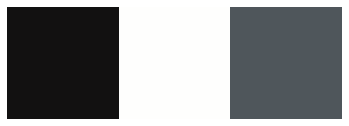

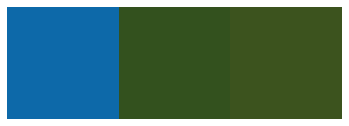

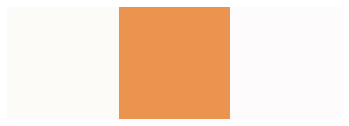

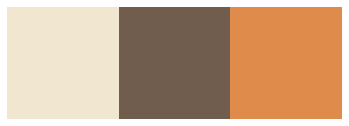

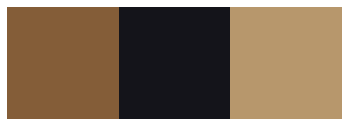

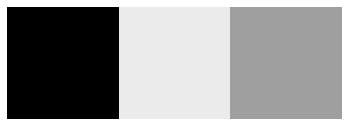

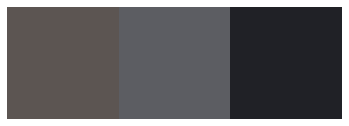

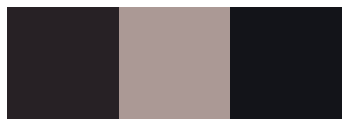

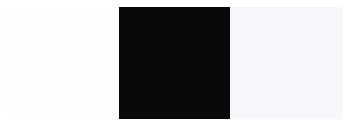

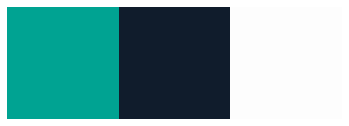

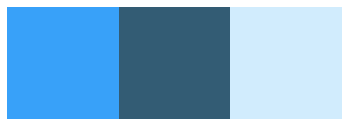

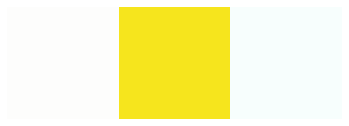

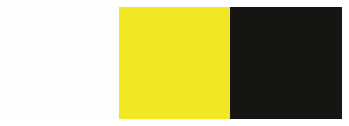

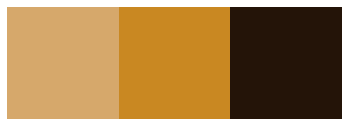

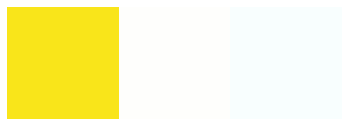

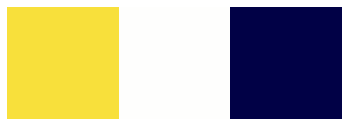

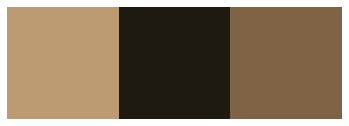

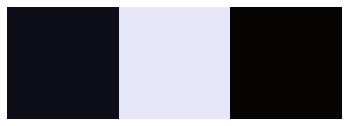

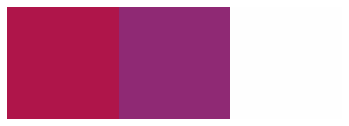

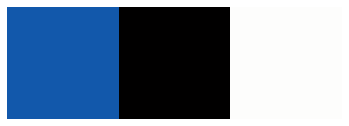

In [54]:
uk_random_images = df[df['account']=='10DowningStreet']['image_path_local'].replace("", np.nan).dropna().sample(20).tolist()
for img in uk_random_images:
    palette = get_palette_for_img(img, 3)
    display_colour_palette(palette)

Generate random palette for Boris images 

Generate random palette sample for the JA images

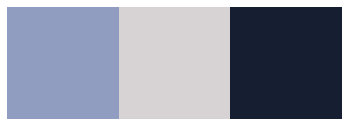

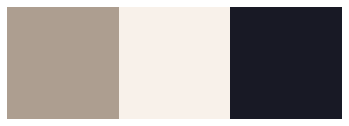

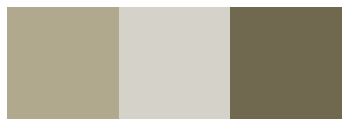

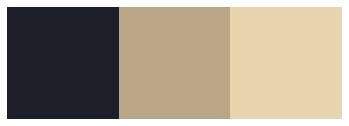

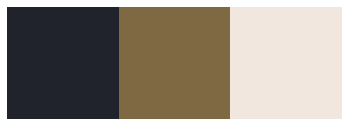

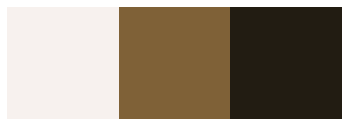

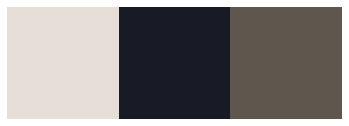

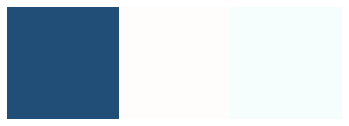

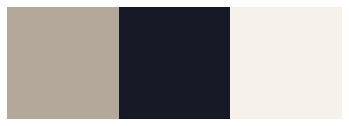

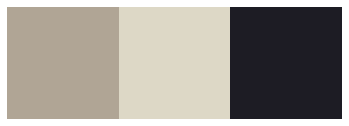

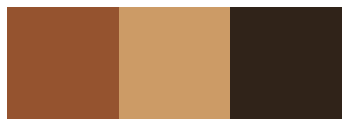

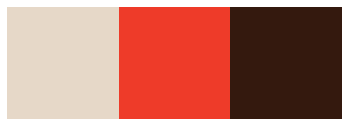

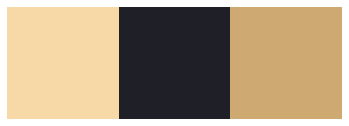

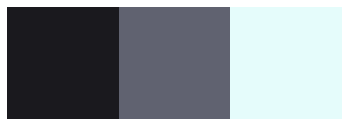

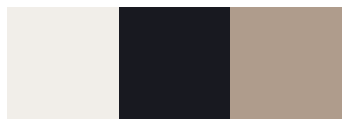

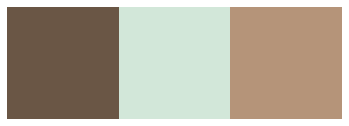

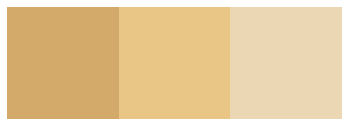

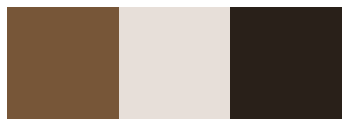

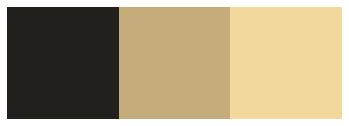

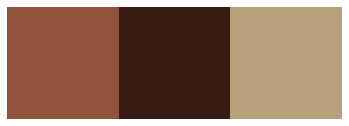

In [56]:
ja_random_images = df[df['account']=='kantei']['image_path_local'].replace("", np.nan).dropna().sample(20).tolist()
for img in ja_random_images:
    palette = get_palette_for_img(img, 3)
    display_colour_palette(palette)

Generate random palette sample for Abe images 

## Tweets over time 

In [57]:
uk_num_tweets_per_day = df[df['account']=='10DowningStreet'].groupby("date")['full_text'].count()
jp_num_tweets_per_day = df[df['account']=='kantei'].groupby("date")['full_text'].count()

boris_num_tweets_per_day = df[df['account']=='BorisJohnson'].groupby("date")['full_text'].count()
abe_num_tweets_per_day = df[df['account']=='AbeShinzo'].groupby("date")['full_text'].count()

### UK

In [58]:
dates = np.array(uk_num_tweets_per_day.index.tolist(), dtype=np.datetime64)
data = np.array(uk_num_tweets_per_day.tolist())
line_range(dates, data, label="UK PM tweets in 20202", line_colour="deepskyblue")

/Users/dea/opt/anaconda3/lib/python3.7/site-packages/bokeh/core/property/bases.py:237: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return new == old
/Users/dea/opt/anaconda3/lib/python3.7/site-packages/bokeh/core/property/bases.py:237: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return new == old


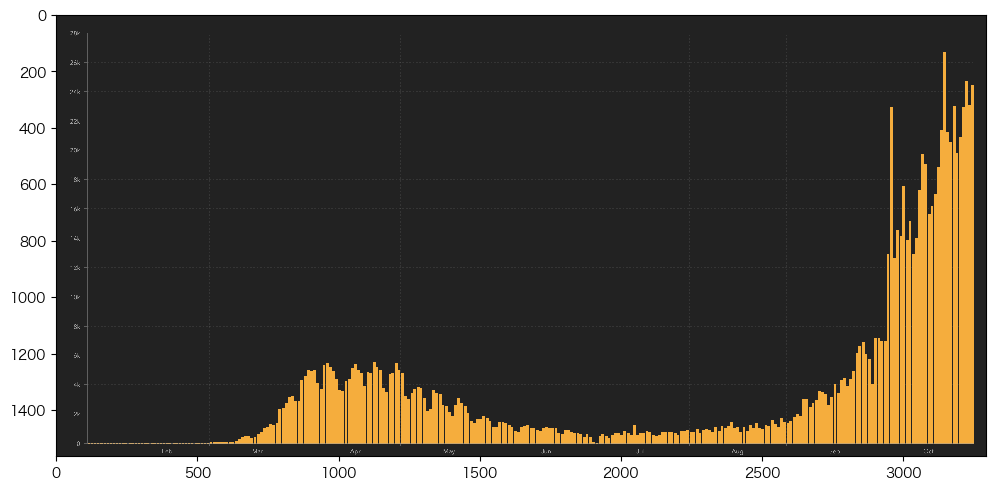

In [64]:
pil_im = Image.open('resources/uk_cases.png', 'r')
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
imshow(np.asarray(pil_im))

### JP

In [62]:
dates = np.array(jp_num_tweets_per_day.index.tolist(), dtype=np.datetime64)
data = np.array(jp_num_tweets_per_day.tolist())
line_range(dates, data, label="JP PM tweets in 2020", line_colour="maroon")

/Users/dea/opt/anaconda3/lib/python3.7/site-packages/bokeh/core/property/bases.py:237: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return new == old
/Users/dea/opt/anaconda3/lib/python3.7/site-packages/bokeh/core/property/bases.py:237: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return new == old


(<Figure size 1440x1440 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8af54f34d0>],
       dtype=object))

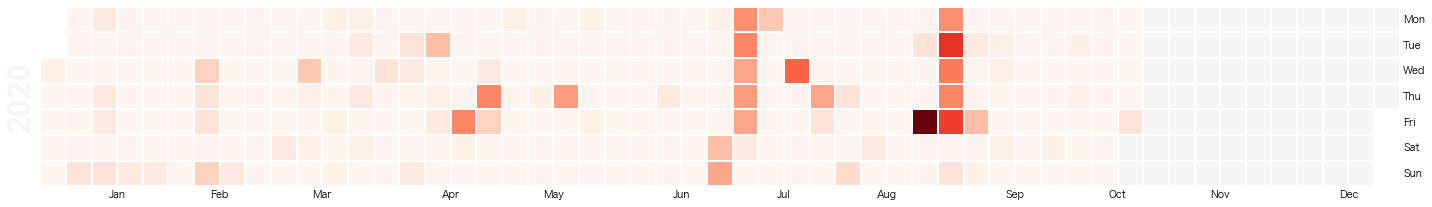

In [63]:
calmap.calendarplot(abe_num_tweets_per_day, fig_kws=dict(figsize=(20, 20)))

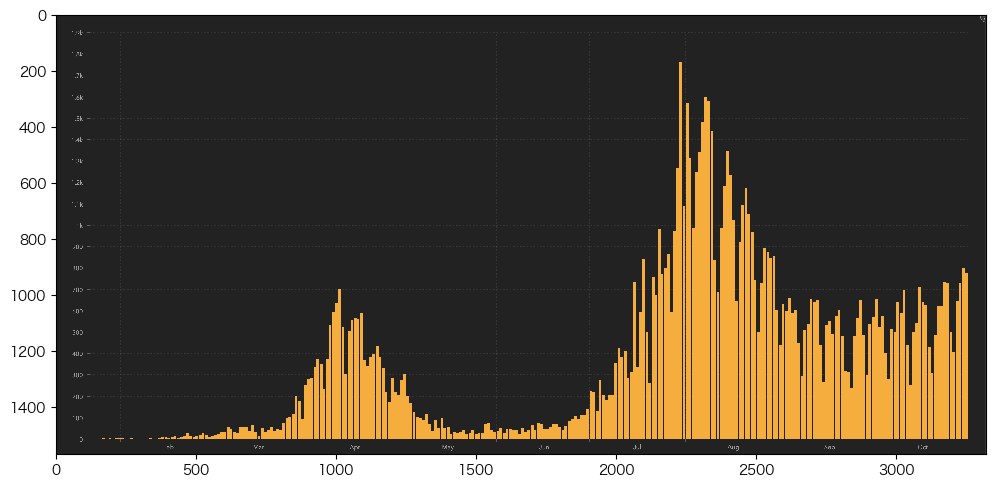

In [65]:
pil_im = Image.open('resources/jp_cases.png', 'r')
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
imshow(np.asarray(pil_im))

## Most and least popular tweets per account 

### by likes 

UK - retweet posts allowed

In [66]:
df[df['account']=='10DowningStreet'].nlargest(10, "retweet_count")['full_text'].tolist()

['RT @BorisJohnson: Over the last 24 hours I have developed mild symptoms and tested positive for coronavirus.\n\nI am now self-isolating, but…',
 'RT @BorisJohnson: It is hard to find the words to express my debt to the NHS for saving my life.\n\nThe efforts of millions of people across…',
 'RT @BorisJohnson: Congratulations @JoeBiden and @KamalaHarris https://t.co/xrpE99W4c4',
 'RT @BorisJohnson: Tonight we have left the EU - an extraordinary turning point in the life of this country. Let us come together now to mak…',
 'RT @BorisJohnson: The Withdrawal Agreement has received\xa0Royal Assent and is now law. We will leave the EU on January 31st 🇬🇧',
 'RT @BorisJohnson: On behalf of the whole country, I want to thank all the incredible nurses, doctors, NHS support staff &amp; carers who are wo…',
 "RT @BorisJohnson: To those going against the advice we're getting from our experts, you're not only putting your own life and the lives of…",
 'RT @BorisJohnson: I just spoke to @JoeBiden to

UK - without the retweet posts

In [67]:
df[(df['account']=='10DowningStreet') & (df['is_retweet'] == False)].nlargest(10, "retweet_count")['full_text'].tolist()

['PM @BorisJohnson gives an important update on #coronavirus \n#StayHomeSaveLives https://t.co/MQo2EVVDcD',
 'Retweet to spread the word. \n\n#StayHomeSaveLives https://t.co/DAvuxlCMUj',
 'PM @BorisJohnson is writing to every UK household to urge them to stay at home, protect the NHS and save lives. \n\n#StayHomeSaveLives https://t.co/GMNPqEl10d',
 'Don’t break the rules. If you do, it won’t just impact you. \n\n#StayHomeSaveLives https://t.co/P0BBoJAk0y',
 'PM @BorisJohnson has announced that everyone must now stay at home except in exceptional circumstances, to protect our NHS and save lives. https://t.co/Pkus4Ep7g6',
 'If you are going for a walk outside or doing grocery shopping, make sure you stay two metres apart from others at all times.\n\n#StaySafeSaveLives https://t.co/6HadWseENg',
 'The government is texting people across the UK to tell them they must stay at home to protect the NHS and save lives.\n\nRetweet to spread the word #StayHomeSaveLives https://t.co/faz4vynPq1',
 '

JP - retweets allowed

In [68]:
df[df['account']=='kantei'].nlargest(10, "retweet_count")['full_text'].tolist()

['官邸スタッフです。\n本日、安倍内閣が総辞職するにあたり、安倍総理からのメッセージです。 https://t.co/5OxHj0rnZJ',
 'RT @Kantei_Saigai: 【お知らせ】特別定額給付金に関するご案内を掲載しました。\n・一人当たり10万円を給付\n・申込方法やよくあるご質問についてのご案内\n・給付金に便乗した詐欺にご注意\n\n定額給付金の詳細・チラシは▼\nhttps://t.co/6VqWfFaOgs…',
 'RT @Kantei_Saigai: 【#新型コロナウイルス】新型インフルエンザ等対策特別措置法、緊急事態宣言について掲載しています。\n緊急事態宣言が行われた場合、\n・欧米におけるロックダウンのように都市が封鎖されますか？\n・外出できなくなりますか？\n等掲載しています。\n\n詳細…',
 'RT @Kantei_Saigai: 【#新型コロナウイルス】本日（4月7日）、下記の通り緊急事態宣言を発出しました。\n\u3000期間：令和2年4月7日～5月6日\n\u3000区域：東京都、神奈川県、埼玉県、千葉県、大阪府、兵庫県、福岡県\u3000の7都府県\n国民の皆様におかれては、十分なご協力をお願い…',
 'RT @Kantei_Saigai: 【#新型コロナウイルス】本日（4月16日）、下記の通り緊急事態宣言の対象を拡大しました。\n\u3000期間：令和2年4月16日～5月6日\n\u3000区域：全都道府県\n国民の皆様におかれては、引き続きのご協力をお願いいたします。',
 'RT @Kantei_Saigai: 【注意喚起】間もなくゴールデンウィークを迎えます。#新型コロナウイルス の感染拡大を防ぐため、人との接触を避けてください。\n・帰省、旅行を控える\n・近場の外出でも密集・密接を避ける\n・買物の際は少人数・最小限の回数に\n医療現場や多くの命を守…',
 'RT @Kantei_Saigai: 【#注意喚起】#新型コロナウイルス を含む #感染症 対策のチラシをHPに掲載しました。\n会社・学校や人の集まる場所での掲示、周知など、用途に限らずご自由に転載・印刷してお使いいただき、身近な方へもぜひお知らせください。\n \nこちらからダウ…',
 'RT @Kantei_Saigai: 【注意

JP - without the retweets 

In [69]:
df[(df['account']=='kantei') & (df['is_retweet'] == False)].nlargest(10, "retweet_count")['full_text'].tolist()

['官邸スタッフです。\n本日、安倍内閣が総辞職するにあたり、安倍総理からのメッセージです。 https://t.co/5OxHj0rnZJ',
 '【お知らせ】本日（3月28日）18時00分頃より、安倍総理の記者会見を本アカウントなどでライブ配信する予定です。ぜひご覧ください。\nFacebook：https://t.co/nwsd1UGvXO\nYouTube：https://t.co/cmAxWg96rN\nInstagram：https://t.co/do2nwewxbU（別アングル） https://t.co/z0u8M4NNdA',
 '【お知らせ】本日（9月16日）第99代内閣総理大臣に菅義偉が指名されました。 https://t.co/MsESMdkZeI',
 '【SNS更新】「医療従事者をはじめ、新型コロナウイルス感染症への対応に全力を尽くして下さっている皆様に、敬意と感謝の気持ちを込めて、明日、航空自衛隊のブルーインパルスが、東京都上空を飛行します。」総理メッセージの続きは\nhttps://t.co/fxOlNUt06N\nhttps://t.co/zgt2cpWdzb https://t.co/wsOvkPd0Bo',
 '安倍内閣総理大臣記者会見 https://t.co/bhqpVS2k6Y',
 '安倍内閣総理大臣記者会見 https://t.co/4RhBQLt4fK',
 '菅総理は、最初の訪問先としてベトナムのハノイに到着し、空港で歓迎の出迎えを受けました。 https://t.co/glYghvsJg0',
 '【お知らせ】本日（4月7日）19時00分頃より、安倍総理の記者会見を本アカウントなどでライブ配信する予定です。ぜひご覧ください。\nFacebook：https://t.co/nwsd1UGvXO\nYouTube：https://t.co/cmAxWg96rN\nInstagram：https://t.co/do2nwewxbU（別アングル） https://t.co/WMeEM1VJ9u',
 '《総理の動き》本日（9月16日）安倍内閣は総辞職しました。この日の閣議で、閣僚の辞表を取りまとめて総辞職を決定した後、内閣総辞職に当たっての内閣総理大臣談話を発出しました。安倍総理は、スタッフたちに見送られながら総理大臣官

### by retweets 

In [70]:
df[df['account']=='10DowningStreet'].nlargest(10, "favorite_count")['full_text'].tolist()

['PM @BorisJohnson gives an important update on #coronavirus \n#StayHomeSaveLives https://t.co/MQo2EVVDcD',
 'PM @BorisJohnson is writing to every UK household to urge them to stay at home, protect the NHS and save lives. \n\n#StayHomeSaveLives https://t.co/GMNPqEl10d',
 'Today is the day the UK is leaving the EU. https://t.co/Zuhzl0l5sT',
 'This evening, Prime Minister @BorisJohnson took part in the weekly Audience of Her Majesty The Queen by telephone from his Downing Street office. https://t.co/coXSH78CoR',
 'WATCH LIVE: PM @BorisJohnson makes a statement outside 10 Downing Street https://t.co/rTLBCBzvDo',
 'PM @BorisJohnson has announced that everyone must now stay at home except in exceptional circumstances, to protect our NHS and save lives. https://t.co/Pkus4Ep7g6',
 '"What shampoo do you use?" - PM @BorisJohnson answers your questions for #PeoplesPMQs https://t.co/Szy7PpN58h',
 'If you are going for a walk outside or doing grocery shopping, make sure you stay two metres apart f

In [71]:
df[df['account']=='BorisJohnson'].nlargest(10, "favorite_count")['full_text'].tolist()

[]

In [72]:
df[df['account']=='kantei'].nlargest(10, "favorite_count")['full_text'].tolist()

['官邸スタッフです。\n本日、安倍内閣が総辞職するにあたり、安倍総理からのメッセージです。 https://t.co/5OxHj0rnZJ',
 '【お知らせ】本日（9月16日）第99代内閣総理大臣に菅義偉が指名されました。 https://t.co/MsESMdkZeI',
 '【SNS更新】「医療従事者をはじめ、新型コロナウイルス感染症への対応に全力を尽くして下さっている皆様に、敬意と感謝の気持ちを込めて、明日、航空自衛隊のブルーインパルスが、東京都上空を飛行します。」総理メッセージの続きは\nhttps://t.co/fxOlNUt06N\nhttps://t.co/zgt2cpWdzb https://t.co/wsOvkPd0Bo',
 '菅総理は、最初の訪問先としてベトナムのハノイに到着し、空港で歓迎の出迎えを受けました。 https://t.co/glYghvsJg0',
 '《総理の動き》本日（9月16日）安倍内閣は総辞職しました。この日の閣議で、閣僚の辞表を取りまとめて総辞職を決定した後、内閣総辞職に当たっての内閣総理大臣談話を発出しました。安倍総理は、スタッフたちに見送られながら総理大臣官邸を後にしました。https://t.co/VF18e2Zd92 https://t.co/Z4Ev2NDYCr',
 '【SNS更新】「菅義偉です。本日、第99代内閣総理大臣に就任いたしました。行政の縦割り、既得権益、悪しき前例主義を打破し、規制改革を進め、「国民のために働く内閣」をつくります。」\n#菅内閣 #第99代内閣総理大臣\n#国民のために働く内閣\nhttps://t.co/KkbG161gsU\nhttps://t.co/r57MD4r7bf https://t.co/3m1GnvEpnz',
 '菅総理は、訪問中のベトナムにおいて、歓迎式典で盛大な出迎えを受けました。 https://t.co/7n1dJKCd5X',
 '本日、ポンペオ米国国務長官の表敬を受けた後、日米豪印外相会合に参加する米・豪・印の３外相の表敬を受けました。自由で開かれたインド太平洋を実現すべく、しっかり連携していくことを確認しました。 https://t.co/RDEXnJncTd',
 '本日、自衛隊の殉職隊員追悼式に参列し、2,001柱の御霊の前で、追悼の誠を捧げ

In [73]:
df[df['account']=='AbeShinzo'].nlargest(10, "favorite_count")['full_text'].tolist()

[]

# Text Exploration 

In [73]:
uk_tweets = df[df['account']=='10DowningStreet']
# by default it's probably best not to use retweets in the text analysis 
uk_tweets_noRT = uk_tweets[~uk_tweets['full_text'].str.contains("RT")]

boris_tweets = df[df['account']=='BorisJohnson']
# by default it's probably best not to use retweets in the text analysis 
boris_tweets_noRT = boris_tweets[~boris_tweets['full_text'].str.contains("RT")]

In [74]:
jp_tweets = df[df['account']=='kantei']
# by default it's probably best not to use retweets in the text analysis 
jp_tweets_noRT = jp_tweets[~jp_tweets['full_text'].str.contains("RT")]

abe_tweets = df[df['account']=='AbeShinzo']
# by default it's probably best not to use retweets in the text analysis 
abe_tweets_noRT = abe_tweets[~abe_tweets['full_text'].str.contains("RT")]

In [75]:
len(jp_tweets_noRT) / len(jp_tweets)

0.792

In [76]:
len(uk_tweets_noRT) / len(uk_tweets)

0.8330266789328427

## Text cleaning and pre-processing

### Japanese-specific 

### tokenizing Japanese text 

In [77]:
# Nagisa: Takes in a document, returns the list of words
def tokenize_jp_nagisa(text):
    doc = nagisa.tagging(spacy_stopword_removal(text))
    return doc.words

In [78]:
# Spacy: Takes in a document, returns the list of words
def tokenize_jp_spacy(text, remove_stopwords=True):
    if remove_stopwords: 
        doc = nlp_ja((text))
    else:
        doc = nlp_ja(text)
    tokens = [token.text for token in doc if token.is_stop==False]    
    return tokens

### Tweet-specific 

In [79]:
import preprocessor as p

In [80]:
# set the option of what you want to remove from the tweets 
# as a default we want to keep the hashtags and mentions and exclude the urls and emoji
def clean_tweets(exclude_urls=True, exclude_emoji=True, exclude_hashtags=False, exclude_mentions=False):
    if exclude_urls and not exclude_emoji:
        p.set_options(p.OPT.URL)
    elif exclude_urls and exclude_emoji:
        p.set_options(p.OPT.URL, p.OPT.EMOJI)
    elif exclude_urls and exclude_emoji and exclude_hashtags and exclude_mentions:   
        p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.HASHTAG, p.OPT.MENTION) 

In [81]:
clean_tweets()

In [82]:
p.clean('Preprocessor is #awesome 👍 https://github.com/s/preprocessor')

'Preprocessor is #awesome'

In [83]:
def get_emoji(tweet): 
    import preprocessor as p
    emojis = []
    parsed_tweet = p.parse(tweet) 
    if str(parsed_tweet.emojis) != 'None':
        for i in range(len(parsed_tweet.emojis)):        
            emojis.append(parsed_tweet.emojis[i].match)
        return emojis
    else:
        return np.nan

In [84]:
#get_emoji('Preprocessor is #awesome 👍 👍 👍 https://github.com/s/preprocessor')

In [85]:
# helper function to get all the emoji from all the tweets
def get_emoji_from_tweets(df):
    emoji = df['full_text'].apply(lambda x : get_emoji(x))
    emoji = emoji.dropna().tolist()
    emoji = [item for sublist in emoji for item in sublist]
    emoji = pd.DataFrame.from_dict(dict(Counter(emoji)), orient='index', columns=['count'])
    return emoji.sort_values(by='count', ascending=False)

In [86]:
uk_emoji = get_emoji_from_tweets(uk_tweets_noRT)
jp_emoji = get_emoji_from_tweets(jp_tweets_noRT)

boris_emoji = get_emoji_from_tweets(boris_tweets_noRT)
abe_emoji = get_emoji_from_tweets(abe_tweets_noRT)

In [87]:
print("Number of emoji in UK posts: {}".format(uk_emoji['count'].sum()))
print("Number of emoji in JP posts: {}".format(jp_emoji['count'].sum()))

print("Number of emoji in Boris posts: {}".format(boris_emoji['count'].sum()))
print("Number of emoji in Abe posts: {}".format(abe_emoji['count'].sum()))

Number of emoji in UK posts: 1149
Number of emoji in JP posts: 0
Number of emoji in Boris posts: 28
Number of emoji in Abe posts: 0


In [88]:
uk_emoji.head(10)

,count
🔵,744
➡,137
⚫,35
😷,24
🏠,15
🔴,13
💙,13
👐,10
❓,8
👇,8


In [89]:
boris_emoji.head(10)

,count
⚫,6
🔵,3
🎙,3
💬,3
➡,2
🏠,2
🏥,2
🌍,1
👏,1
♥,1


### Text -> bag of words

In [90]:
def text_to_bow_en(text):
    '''
    convert text to just lowercase words
    '''
    # optional if dealing with strings which might contain nan 
    if text == np.nan:
        return text 
    else: 
        text = str(text).lower()
        text = re.sub('\n', ' ', text) 
        text = re.sub('<br>', ' ', text) 
        # remove non alphanumeric characters
        regex = re.compile('[^0-9a-zA-Z- ]')
        text = regex.sub('', text)
        text = re.sub(' +', ' ', text).strip()
        return text

In [91]:
def text_to_bow_ja(text):
    characters_to_remove = "。！？「」、【】《》（）・"
    pattern = "[" + characters_to_remove + "]"

    if text == np.nan:
        return text 
    else: 
        # just in case there are non-Japanese words
        text = str(text).lower()
        # remove new lines and html remnants
        text = re.sub('\n', ' ', text) 
        text = re.sub('<br>', ' ', text) 
        # remove multiple spaces
        text = re.sub(' +', ' ', text).strip()
        # optional - remove punctuation 
        text = re.sub(pattern, "", text)
        # very simple link removal 
        text = re.sub(r"http\S+", "", text)
        return text

### stopword removal

In [92]:
# Stop words removal with spacy but without lemmatizing 
def spacy_stopword_removal(text, nlp, language="en"):
    doc = nlp((text))
    doc_tokens = []
    for token in doc:
        if token.is_stop == False:
            doc_tokens.append(token.text)
    if language == "en":
        lemmatized_text = " ".join(doc_tokens)
    elif language == 'ja':
        lemmatized_text = "".join(doc_tokens)
    return lemmatized_text

### lemmatisation 

In [93]:
# For a single string
def spacy_lemmatize_text(text):
    doc = nlp(text_to_bow(text))
    doc_tokens = []
    for token in doc:
        if token.is_stop == False:
            doc_tokens.append(token.lemma_)
    lemmatized_text = "".join(doc_tokens)
    return lemmatized_text

### --> Clean the text 
Important: the tweepy cleaning api doesn't seem to work with japanese text -- will need to fix this for later model training 
- 1. clean the tweet with tweepy, which removed urls and emoji but leaves # and @
- 2. clean with text_to_bow which leaves only words and lowercases everything and removed the # and @ signs 
- 3. remove stopwords 

In [94]:
uk_tweets_noRT_cleaned = uk_tweets_noRT['full_text'].apply(lambda x : 
        spacy_stopword_removal(text_to_bow_en(p.clean(x)), nlp_en, "en")
    )
uk_tweets_noRT['full_text_cleaned'] = uk_tweets_noRT_cleaned

/Users/dea/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [95]:
jp_tweets_noRT_cleaned = jp_tweets_noRT['full_text'].apply(lambda x : 
        spacy_stopword_removal(text_to_bow_ja(x), nlp_ja, "ja")
    )
jp_tweets_noRT['full_text_cleaned'] = jp_tweets_noRT_cleaned

/Users/dea/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [96]:
jp_tweets_noRT_cleaned.head(5).tolist()

['総理動き本日10月30日菅総理官邸地球温暖化対策推進本部開催まし2050年カーボンニュートラル挑戦日本新た成長戦略挑戦産業構造経済社会発展つなげ経済環境好循環生み出しいき思い挨拶全文',
 '#温暖化対策推進本部#地球温暖化対策計画#2050年#カーボンニュートラル@sugawitter',
 '2050年カーボンニュートラル挑戦日本新た成長戦略挑戦産業構造経済社会発展つなげ経済環境好循環生み出しいき思い温暖化対策推進本部開催全閣僚対し地球温暖化対策計画見直し加速指示まし',
 '坂井官房副長官記者会見本日10月30日午後動画掲載まし',
 '坂井官房副長官記者会見本日10月30日午前動画掲載まし']

## Bag of Words 

In [97]:
class BagOfWords:
    def __init__(self, data, max_df, min_df, stop_words, ngram_range, change_tokenizer=False, tokenizer=None) :
        self.data = data
        self.max_df = max_df 
        self.min_df = min_df 
        self.stop_words = stop_words 
        self.ngram_range = ngram_range 
        if change_tokenizer == True: 
            self.MyCountVectorizer = CountVectorizer(
                tokenizer=tokenizer,
                max_df=self.max_df, 
                min_df=self.min_df, 
                stop_words=self.stop_words, 
                ngram_range=self.ngram_range)
        else:   
            self.MyCountVectorizer = CountVectorizer(
                max_df=self.max_df, 
                min_df=self.min_df, 
                stop_words=self.stop_words, 
                ngram_range=self.ngram_range)
        # init the empty vars 
        self.X = ""
        self.feature_names = ""
        self.counts = ""
        self.df_counts = ""
        self.dict_counts = ""
        self.wordcloud = ""
        self.p = ""
        
    #fit the count vectorizer 
    def fit_transform(self):
        self.X = self.MyCountVectorizer.fit_transform(self.data)

    def get_feature_names(self):
        self.feature_names = self.MyCountVectorizer.get_feature_names()

    def get_bow_feature_counts(self): 
        self.counts = self.X.toarray().sum(axis=0)
        # create a df with feature names and counts 
        self.df_counts = pd.DataFrame({"feature_names": self.feature_names, "counts": self.counts}).sort_values(by="counts", ascending=False)

    # get the data into a dict format of {word: freq} type to feed into the wordcloud 
    def prep_for_wordcloud(self):
        _dict_counts = self.df_counts.set_index("feature_names").to_dict(orient="index")
        self.dict_counts = {}
        for keyword, count in _dict_counts.items():
            self.dict_counts[keyword] = count['counts']

    # visualise the word cloud
    def viz_wordcloud(self, background_color="black", max_words=200, width=700, height=400):
        self.wordcloud = WordCloud(background_color=background_color, max_words=max_words, width=width, height=height)
        self.wordcloud.generate_from_frequencies(self.dict_counts)
        #self.wordcloud.to_image()
            
        # bar chart of word frequencies 
    def barchart_wordfreq(self, 
                              num_top_features=30,
                              output_here=True, save_filename="plot", 
                              plot_height=350, plot_width=800, title="Title", bgcolor = "#2b2b2b"):

        counted_data = self.df_counts.nlargest(num_top_features, "counts")["feature_names"].tolist()
        counts = self.df_counts.nlargest(num_top_features, "counts")["counts"].tolist()
        # either display in the notebook or save file 
        if output_here:
            output_notebook()
        else:
            output_file(save_filename+".html")

        source = ColumnDataSource(data=dict(counted_data=counted_data, counts=counts))
        self.p = figure(x_range=counted_data, plot_height=plot_height, plot_width=plot_width, toolbar_location=None, title=title)

        self.p.vbar(x='counted_data',
               top='counts', 
               width=0.8, 
               source=source, 
               line_color='white', 
               fill_color=factor_cmap('counted_data', palette=cividis(len(counted_data)), factors=counted_data))

        self.p.xgrid.grid_line_color = None
        self.p.ygrid.grid_line_color = None
        self.p.y_range.start = 0
        self.p.xaxis.major_label_orientation = 1.2
        #p.y_range.end = 5000
        self.p.background_fill_color = bgcolor
        show(self.p)

### --> Bag of Words English

In [98]:
# initialize the count vectorizer 
data_uk = uk_tweets_noRT['full_text_cleaned'].tolist()
bow_uk = BagOfWords(data=data_uk, max_df=0.98, min_df=0.005, ngram_range=(1, 1),
                    stop_words=None, change_tokenizer=False)
# fit transform and get the fit-transformed matrix of word frequencies
bow_uk.fit_transform() #bow_bow.X
# get the feature names 
bow_uk.get_feature_names() #bow.feature_names
# get the feature counts 
bow_uk.get_bow_feature_counts() #bow.df_counts

In [99]:
print("Number of features: {}".format(len(bow_uk.feature_names)))

Number of features: 407


In [100]:
bow_uk.barchart_wordfreq(num_top_features=20, plot_width=700)


Loading BokehJS ...

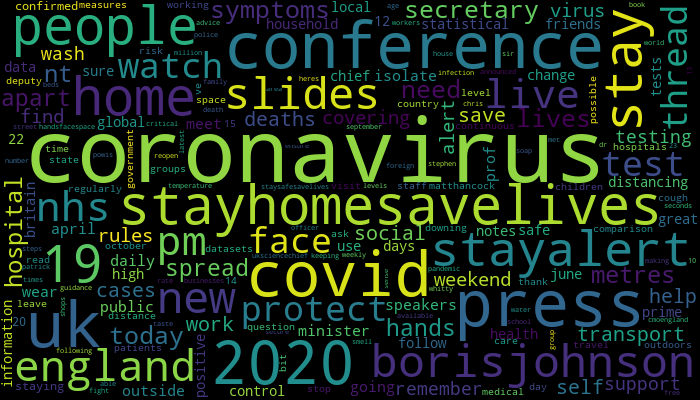

In [101]:
# wordcloud 
bow_uk.prep_for_wordcloud()
bow_uk.viz_wordcloud()
bow_uk.wordcloud.to_image()

### --> Bag of Words Japanese 

In [102]:
# initialize the count vectorizer 
data_jp = jp_tweets_noRT['full_text_cleaned'].tolist()
bow_ja = BagOfWords(data=data_jp, max_df=0.98, min_df=0.005, ngram_range=(1, 1),
                    stop_words=None, change_tokenizer=True, tokenizer=tokenize_jp_spacy)
# fit transform and get the fit-transformed matrix of word frequencies
bow_ja.fit_transform() #bow_bow.X
# get the feature names 
bow_ja.get_feature_names() #bow.feature_names
# get the feature counts 
bow_ja.get_bow_feature_counts() #bow.df_counts

In [103]:
print("Number of features: {}".format(len(bow_ja.feature_names)))

Number of features: 467


In [104]:
# wordcloud 
bow_ja.prep_for_wordcloud()
bow_ja.viz_wordcloud()
#bow_ja.wordcloud.to_image()

In [105]:
bow_ja.barchart_wordfreq(num_top_features=20, plot_width=700)
#show(bow.p)

Loading BokehJS ...

In [106]:
# initialize the count vectorizer 
bow_2grams_ja = BagOfWords(data=data_jp, max_df=0.999, min_df=0.001, ngram_range=(2, 2),
                    stop_words=None, change_tokenizer=True, tokenizer=tokenize_jp_spacy)
bow_2grams_ja.fit_transform() #bow_bow.X
bow_2grams_ja.get_feature_names() #bow.feature_names
bow_2grams_ja.get_bow_feature_counts() #bow.df_counts

In [107]:
bow_2grams_ja.barchart_wordfreq(num_top_features=20, plot_width=700)

Loading BokehJS ...

## Topic Modelling with LDA

In [108]:
# pass in the bow data and the vectorizer that was used to obtain in 
class TopicModelling:
    def __init__(self, bow_data, vectorizer, n_components, n_top_words):
        self.bow_data = bow_data
        self.n_components = n_components 
        self.n_top_words = n_top_words
        self.vectorizer = vectorizer
        self.lda = LDA(n_components=n_components, 
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
        self.feature_names = ""
        self.top_topic_words = {}
        
    def fit(self):
        self.lda.fit(self.bow_data)
        
    # get the features from the passed vectorizer
    def get_feature_names(self):
        self.feature_names = self.vectorizer.get_feature_names()
       
    def get_top_topic_words(self):
        for topic_idx, topic in enumerate(self.lda.components_):
            self.top_topic_words["topic_" + str(topic_idx)] = " ".join([self.feature_names[i] for i in topic.argsort()[:-self.n_top_words - 1:-1]])
            
    # predic the topics 
    def pred(self, data):
        return self.lda.transform(data)
    
    # make a dataframe out of the predictions 
    def preds_to_df(self, data):
        preds = self.pred(data)
        preds_df = pd.DataFrame(preds)
        preds_df.columns = ["topic_" + str(i) for i in preds_df.columns.tolist()]
        return preds_df
    
    def visualise_lda(self, data, filename="lda_visualised"):
        LDAvis_prepared = sklearn_lda.prepare(self.lda, data, self.vectorizer)
        pyLDAvis.save_html(LDAvis_prepared, os.path.join(filename + '.html'))

In [109]:
# vectorized_data=bow.X, data_vectorizer=bow.MyCountVectorizer, n_components=10, n_top_words=20, filename="test"
def get_lda(vectorized_data, data_vectorizer, n_components=10, n_top_words=20, filename="test"):
    
    lda = TopicModelling(bow_data=vectorized_data, vectorizer=data_vectorizer, n_components=n_components, n_top_words=n_top_words)
    # fit the lda model 
    lda.fit()
    # get the vectorizer feature names 
    lda.get_feature_names()
    # get the top words for each topic 
    lda.get_top_topic_words()
    
    lda_preds = lda.pred(vectorized_data)
    preds_df = lda.preds_to_df(vectorized_data)
    
    lda.visualise_lda(vectorized_data, filename+str(n_components))

    return lda, lda_preds, preds_df

### --> LDA for English 

In [110]:
uk_lda5, uk_lda_preds5, uk_preds_df5 = get_lda(
    vectorized_data = bow_uk.X,
    data_vectorizer = bow_uk.MyCountVectorizer,
    n_components=5,
    n_top_words=20,
    filename = "uk_tweets_5topics"
)

In [111]:
uk_lda5.top_topic_words

{'topic_0': 'borisjohnson pm coronavirus symptoms minister support new today prime need test help work uk met self world people find isolate',
 'topic_1': 'stayalert face stay metres apart hands public covering wash virus wear remember transport work control outside coronavirus protect regularly spread',
 'topic_2': 'stayhomesavelives home nhs lives stay save coronavirus protect rules safe staying staff spread thank covid working bit weekend secure workers',
 'topic_3': 'people nt meet england friends stayalert information social days outdoors groups self travel isolate coronavirus mp distancing outside 14 family',
 'topic_4': 'coronavirus conference press 2020 uk covid 19 slides thread secretary watch live hospital cases deaths new people speakers daily prof'}

In [112]:
uk_lda10, uk_lda_preds10, uk_preds_df10 = get_lda(
    vectorized_data = bow_uk.X,
    data_vectorizer = bow_uk.MyCountVectorizer,
    n_components=10,
    n_top_words=20,
    filename = "uk_tweets_10topics"
)

In [113]:
uk_lda10.top_topic_words

{'topic_0': 'going question day ask pm borisjohnson downing street thank coronavirus staff happy school minister country today prime schools questions children',
 'topic_1': 'face public covering wear stayalert transport rules people safe virus protect follow control space shops england spread nt remember enclosed',
 'topic_2': 'stayalert metres apart stay outside meet nt people remember weekend england outdoors household house friends groups social leave sure ones',
 'topic_3': 'new pm borisjohnson change cough high temperature continuous today eu sense taste smell loss test work uk free symptoms visited',
 'topic_4': 'coronavirus uk press conference 19 covid slides 2020 thread hospital deaths cases hands new people daily wash data great britain',
 'topic_5': 'stayhomesavelives home stay nhs lives protect save coronavirus help work spread staying support weekend need virus health bit safe ensure',
 'topic_6': 'coronavirus symptoms self isolate need test days find nhs 14 support people

### --> LDA for Japanese 

In [114]:
jp_lda5, jp_lda_preds5, jp_preds_df5 = get_lda(
    vectorized_data = bow_ja.X,
    data_vectorizer = bow_ja.MyCountVectorizer,
    n_components=5,
    n_top_words=20,
    filename = "jp_tweets_5topics"
)

In [115]:
jp_lda5.top_topic_words

{'topic_0': 'まし 総理 コロナ   更新 sns 新型 ウイルス 感染 年 症 メッセージ # 全文 日本 経済 関係 対策 皆 日',
 'topic_1': '総理 まし 月 日 動き 安倍 官邸 本日 会議 1 第 行い 回 出席 及び 開催 大臣 2 行わ 内閣',
 'topic_2': '： ください ご覧 会見 instagram 本日 総理 記者 更新 安倍 まし 月 日 ライブ 配信 ぜひ 知らせ 時 頃 アカウント',
 'topic_3': '記者 会見 官房 長官 掲載 動画 月 まし 本日 日 菅 午前 午後 発言 冒頭 ］ ［ 閣議 概要 7',
 'topic_4': '者 式 @ # 慰霊 平和 sugawitter 震災 追悼 東 会議 戦没 大 祈念 関係 規制 原爆 関する 周年 改革'}

In [116]:
jp_lda10, jp_lda_preds10, jp_preds_df10 = get_lda(
    vectorized_data = bow_ja.X,
    data_vectorizer = bow_ja.MyCountVectorizer,
    n_components=10,
    n_top_words=20,
    filename = "jp_tweets_10topics"
)

In [117]:
jp_lda10.top_topic_words

{'topic_0': '総理 まし sns 更新   メッセージ # 年 全文 日本 皆 続き 国民 年頭 スタッフ ください 発言 ご覧 内閣 いたし',
 'topic_1': '総理 まし 月 日 安倍 動き 官邸 本日 会議 1 第 回 出席 及び 行い 開催 大臣 2 行わ 内閣',
 'topic_2': '記者 会見 本日 月 日 まし 動画 掲載 長官 官房 菅 午後 午前 6 9 3 2 7 1 5',
 'topic_3': '冒頭 発言 官房 ［ ］ 長官 掲載 記者 動画 会見 月 本日 日 まし 午前 閣議 菅 概要 7 1',
 'topic_4': '@ sugawitter 成長 # 戦略 日 まし 的 19 総理 国 開催 会合 まとめ 制度 行っ いただき 設置 考え 10',
 'topic_5': 'コロナ 経済 新型 まし ウイルス 感染 症 会議 関する 更新 関係 instagram ストーリーズ 公開 地方 対策 閣僚 拡大 財政 g',
 'topic_6': '後 行っ スピーチ 配信 ライブ 懇談 sns 知らせ ご覧 ： ください 状況 閣議 願い いただき 初 撮影 通信 内閣 行い',
 'topic_7': '会談 まし 行い 訪問 インド 首相 太平洋 ベトナム 国 関係 首脳 中 国王 自由 皇太子 インドネシア 協力 開か 歓迎 殿下',
 'topic_8': '大会 東京 オリンピック パラリンピック まし 総理 10 月 本日 日 報告 状況 17 菅 官邸 本部 会議 2020 動き 実施',
 'topic_9': '者 御 方々 まし 式 平和 世代 戦没 全 型 保障 祈念 社会 心 原爆 デジタル 検討 慰霊 安全 安心'}

## Spacy features

### Part of speech 
- Counting the number of nouns, noun phrases, verbs, adjectives etc

In [118]:
wanted_pos = ['PROPN', "VERB", "NOUN", "ADV", "ADJ"]

In [119]:
# for a single string of text, return a list of the words of the desired pos type
# and a list of the corresponding lemmas 
def collect_single_pos(pos, text, nlp, stopword=False):
    pos_text = []
    pos_lemma = []
    doc = nlp(text)
    for token in doc:
        if token.pos_ == pos and token.is_stop == False:
            pos_text.append(token.text)
            pos_lemma.append(token.lemma_)
    return pos_text, pos_lemma

In [120]:
def collect_noun_chunks(text):
    noun_chunks = []
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        noun_chunks.append(chunk.text)
    return noun_chunks

In [121]:
# collect the pos for a single piece of text
def collect_pos_text(text, nlp):
    doc = nlp(text)
    nouns, verbs, adverbs, adjectives, other_pos = [], [], [], [], []
    for token in doc: 
        if token.pos_ == "NOUN" or token.pos_ == "PROPN":
            nouns.append(token.lemma_)
        elif token.pos_ == "VERB":
            verbs.append(token.lemma_)
        elif token.pos_ == "ADV":
            adverbs.append(token.lemma_)
        elif token.pos_ == "ADJ":
            adjectives.append(token.lemma_)
        else:
            other_pos.append(token.text)
    return nouns, verbs, adverbs, adjectives, other_pos

In [122]:
def collect_pos_list(texts_list, nlp):
    nouns_all, verbs_all, adverbs_all, adjectives_all, other_pos_all =  [], [], [], [], []
    for text in texts_list:
        nouns, verbs, adverbs, adjectives, other_pos = collect_pos_text(text=text, nlp=nlp)
        nouns_all.extend(nouns)
        verbs_all.extend(verbs)
        adverbs_all.extend(adverbs)
        adjectives_all.extend(adjectives)
        other_pos_all.extend(other_pos)
    all_pos = {}
    all_pos['nouns'] = len(nouns_all)
    all_pos['verbs'] = len(verbs_all)
    all_pos['adverbs'] = len(adverbs_all)
    all_pos['adjectives'] = len(adjectives_all)
    return all_pos, nouns_all, verbs_all, adverbs_all, adjectives_all, other_pos_all

### --> POS for English

In [123]:
all_pos, nouns_all, verbs_all, adverbs_all, adjectives_all, other_pos_all = collect_pos_list(texts_list=data_uk, nlp=nlp_en)

In [124]:
uk_all_pos = pd.DataFrame.from_dict(all_pos, orient="index", columns=['count']).reset_index()
piechart(uk_all_pos, "index", "count", "Count of part of speech in tweets -- UK")

### --> POS for Japanese 

In [125]:
all_pos_jp, nouns_all_jp, verbs_all_jp, adverbs_all_jp, adjectives_all_jp, other_pos_all_jp = collect_pos_list(texts_list=data_jp, nlp=nlp_ja)

In [126]:
jp_all_pos = pd.DataFrame.from_dict(all_pos_jp, orient="index", columns=['count']).reset_index()
piechart(jp_all_pos, "index", "count", "Count of part of speech in tweets -- Japan")

## Sentiment Analysis 

### Google sentiment analysis API

In [127]:
from google.cloud import language_v1
from google.cloud.language_v1 import enums

In [128]:
def analyze_sentiment_google(text, language="en"):
    client = language_v1.LanguageServiceClient()
    type_ = enums.Document.Type.PLAIN_TEXT

    document = {"content": text, "type": type_, "language": language}

    encoding_type = enums.EncodingType.UTF8

    response = client.analyze_sentiment(document, encoding_type=encoding_type)

    return response.document_sentiment.score

In [129]:
analyze_sentiment_google("君のことが嫌い", "ja")

Compute Engine Metadata server unavailable onattempt 1 of 3. Reason: timed out
Compute Engine Metadata server unavailable onattempt 2 of 3. Reason: timed out
Compute Engine Metadata server unavailable onattempt 3 of 3. Reason: [Errno 64] Host is down
Authentication failed using Compute Engine authentication due to unavailable metadata server.


DefaultCredentialsError: Could not automatically determine credentials. Please set GOOGLE_APPLICATION_CREDENTIALS or explicitly create credentials and re-run the application. For more information, please see https://cloud.google.com/docs/authentication/getting-started

### Transformers 

In [130]:
import tensorflow as tf
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

/Users/dea/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py:546: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class IteratorBase(collections.Iterator, trackable.Trackable,
/Users/dea/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:106: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class DatasetV2(collections.Iterable, tracking_base.Trackable,


#### japanese

In [116]:
def tokenize_japanese():
    # for japanese sentiment analysis 
    tokenizer = AutoTokenizer.from_pretrained("daigo/bert-base-japanese-sentiment")
    model = AutoModelForSequenceClassification.from_pretrained("daigo/bert-base-japanese-sentiment")
    nlp = pipeline("sentiment-analysis", tokenizer=tokenizer, model=model)
    return tokenizer, model, nlp

In [117]:
def analyse_sentiment_transformers_japanese(text, nlp):
    sentiment = nlp(text)
    if sentiment[0]["label"] == "ポジティブ":
        return sentiment[0]['score']
    else: 
        return -sentiment[0]['score']

In [118]:
tokenizer_ja, model_ja, transformers_nlp_ja = tokenize_japanese()

In [119]:
analyse_sentiment_transformers_japanese("君のことが大嫌い", transformers_nlp_ja)

-0.6884356141090393

#### english

In [120]:
transformers_nlp_en = pipeline("sentiment-analysis")
def analyse_sentiment_transformers_english(text, nlp):
    sentiment = nlp(text)
    if sentiment[0]["label"] == "POSITIVE":
        return sentiment[0]['score']
    else: 
        return -sentiment[0]['score']

In [121]:
analyse_sentiment_transformers_english("I really don't like you", transformers_nlp_en)

-0.9991559386253357

### --> Sentiment Analysis English

In [122]:
# use the text before cleaning, and just clean the urls with tweepy; include the retweets 
uk_tweets['sentiment_transformers'] = uk_tweets['full_text'].apply(
    lambda x : analyse_sentiment_transformers_english(p.clean(x), transformers_nlp_en)
)

/Users/dea/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [123]:
print("Average sentiment for all UK tweets: {}".format(uk_tweets['sentiment_transformers'].mean()))

Average sentiment for all UK tweets: -0.07389892663775832


In [124]:
uk_tweets.nsmallest(10, 'sentiment_transformers')[['full_text', 'sentiment_transformers']]['full_text'].tolist()

["RT @BorisJohnson: I'm deeply saddened to hear of the attack at the London Central Mosque. It's so awful that this should happen, especially…",
 'If you have any of the following coronavirus symptoms: \n \n1⃣ A new continuous cough\n2⃣ A high temperature\n3⃣ A change or loss of your sense of taste or smell\n \nYou should self-isolate and get a test now: https://t.co/RtC0g38NAj https://t.co/leiyFpsXwr',
 'If you have coronavirus symptoms, you need to self-isolate and book a free test now.\n \nhttps://t.co/aIOcmAlqti https://t.co/WpYnCLKQN2',
 'You should self-isolate if you develop:\n\n🔵 a new continuous cough\n🔵 fever\n🔵 loss/change in your normal sense of smell or taste https://t.co/1Jiw6H4fEY',
 'Avoid public transport if you can.\n\nWalk, cycle or drive instead.\n\n#StayAlert https://t.co/CmJDmkZVqx',
 'If you have symptoms of coronavirus, or you have tested positive for coronavirus, then you MUST self-isolate for 10 days. https://t.co/z4u4IXgsLt',
 'You should self-isolate if you 

### --> Sentiment Analysis Japanese

In [125]:
# use the text before cleaning, and just clean the urls with tweepy; include the retweets 
jp_tweets['sentiment_transformers'] = jp_tweets['full_text'].apply(
    lambda x : analyse_sentiment_transformers_japanese(text_to_bow_ja(x), transformers_nlp_ja)
)

/Users/dea/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [126]:
print("Average sentiment for all Japanese tweets: {}".format(jp_tweets['sentiment_transformers'].mean()))

Average sentiment for all Japanese tweets: 0.849256512761116


In [127]:
jp_tweets.nsmallest(10, 'sentiment_transformers')[['full_text', 'sentiment_transformers']]['full_text'].tolist()

['【菅官房長官・記者会見】本日（4月28日）午前の動画を掲載しました。\n［冒頭発言］持ち回り閣議の概要、閣僚の給与の一部返納について\nhttps://t.co/qkvtlRElMG',
 '【菅官房長官・記者会見】本日（8月7日）午前の動画を掲載しました。\n［冒頭発言］閣議の概要、内閣官房副長官補の人事についてhttps://t.co/S5Uj6v2VcH',
 '【加藤官房長官・記者会見】本日（9月18日）午後の動画を掲載しました。\n［冒頭発言］閣議の概要、副大臣及び大臣政務官の人事について\nhttps://t.co/kojw6ySGJ3',
 'RT @Kantei_Saigai: 「大型客船内での集団感染という新たな事態の発生に直面しましたが、乗員・乗客の方々の健康状態に十分配慮しつつ、感染の拡大防止に向けて万全の対策を講じなくてはなりません。」（2/4）',
 '【菅官房長官・記者会見】本日（6月26日）午前の動画を掲載しました。\n［冒頭発言］閣議の概要、内閣官房副長官補の人事について\nhttps://t.co/YGf1cmZss3',
 '菅官房長官・記者会見】本日（5月22日）午前の動画を掲載しました。\n [冒頭発言]持ち回り閣議の概要、南スーダン国際平和協力業務実施計画の変更等の決定についてhttps://t.co/hid6vSYNJz',
 '【加藤官房長官・記者会見】本日（10月16日）午前の動画を掲載しました。\n［冒頭発言］閣議の概要、菅総理のベトナム及びインドネシア訪問、「日本経済再生本部の設置について」の廃止についてhttps://t.co/TSEC21IOy1',
 '【菅官房長官・記者会見】本日（7月14日）午前の動画を掲載しました。\n［冒頭発言］閣議の概要、内閣官房及び内閣総理大臣秘書官の人事について\nhttps://t.co/eo23y3jvu7',
 '【菅官房長官・記者会見】本日（4月10日）午前の動画を掲載しました。\n［冒頭発言］持ち回り閣議の概要について\n４月１９日に挙行する予定の立皇嗣の礼についてhttps://t.co/qne1DdmbWy',
 '【菅官房長官・記者会見】本日（9月4日）午前の動画を掲載しました。\n［冒頭発言］閣議の概要、内閣官房の人事について\nhttps://t.co/T

In [130]:
sample_tweets = jp_tweets['full_text'].sample(500)
porg = sample_tweets.apply(
    lambda x : analyze_sentiment_google(text_to_bow_ja(x), "ja")
)

In [132]:
porg.mean()

-0.0010000001490116119

In [153]:
porg_df = pd.DataFrame(porg)
porg_df.columns = ['score']
porg_df['full_text'] = pd.DataFrame(sample_tweets)['full_text']

In [157]:
porg_df.nsmallest(10, 'score')['full_text'].tolist()

['RT @Kantei_Saigai: 【#新型コロナウイルス】大半の市区町村で10万円給付金の受付が始まっています。\n市区町村から申請書が届きますので、郵送での返信やオンラインなどで申請してください。\n給付金に絡む個人情報の聞き出しやニセホームページにはご注意ください。\n \n詳…',
 'RT @Kantei_Saigai: 【注意喚起】#新型コロナウイルス の発生について、感染症危険レベルが引き上げられた地域があります。\n韓国・大邱広域市及び慶尚北道清道郡に関してレベル2：不要不急の渡航は止めてください。（新規）\nhttps://t.co/PShUeTVoFb…',
 'RT @Kantei_Saigai: 【#新型コロナウイルス】中小法人・個人事業者のための「持続化給付金」の申請が始まっています。\n\n申請期間：令和2年5月1日～令和3年1月15日\n給付：申請後、通常2週間程度\n※「持続化給付金」を装った詐欺にもご注意ください。\n\n申請手続きや…',
 'RT @Kantei_Saigai: 【お知らせ】特別定額給付金に関するご案内を掲載しました。\n・一人当たり10万円を給付\n・申込方法やよくあるご質問についてのご案内\n・給付金に便乗した詐欺にご注意\n\n定額給付金の詳細・チラシは▼\nhttps://t.co/6VqWfFaOgs…',
 'RT @Kantei_Saigai: 「ーーまた、行政機関や民間企業等におかれては、引き続き、休みが取りやすくなる環境を整えていただくとともに、子どもを持つ保護者の方々への配慮をお願いします。」(3/3)\n総理発言の全文はhttps://t.co/w99xdpGl1I',
 'RT @Kantei_Saigai: 【注意喚起】#新型コロナウイルス の発生について、感染症危険レベルが引き上げられた地域があります。（1/4）\n●スイス\n・ティチーノ州\nレベル２：不要不急の渡航は止めてください。（引き上げ）\n・その他の地域\nレベル１：十分注意してください。…',
 'RT @Kantei_Saigai: （続き）「国内の複数地域で、感染経路が明らかではない患者が発生しています。現時点は、大規模な感染拡大を防止する上で、重要な局面です。」\n総理発言の全文はhttps://t.co/z